In [396]:
# !/usr/bin/python
# -*- coding: utf-8 -*-
from math import log
from PIL import Image, ImageDraw
from IPython.display import Image

In [397]:
# create ratings.dat dictionary
rentOriginalData = open("./RentData/SmallTestData.csv","r")
rentData = []

for rent in rentOriginalData:
    # 去掉\n後，用,區分
    rentData.append(rent.strip().split(','))

print (len(rentData))

12


In [398]:
class decisionnode:
  def __init__(self,col=-1,value=None,results=None,tb=None,fb=None):
    self.col = col
    self.value = value
    self.results = results
    self.tb = tb
    self.fb = fb
    
    
# Divides a set on a specific column. Can handle numeric
# or nominal values
def divideset(rows,column,value):
   # Make a function that tells us if a row is in 
   # the first group (true) or the second group (false)
   split_function = None
   if isinstance(value,int) or isinstance(value,float):
      split_function = lambda row:row[column] >= value
   else:
      split_function = lambda row:row[column] == value
   
   # Divide the rows into two sets and return them
   set1=[row for row in rows if split_function(row)]
   set2=[row for row in rows if not split_function(row)]
   return (set1,set2)

In [399]:
divideset(rentData,22,'13500')
# divideset(rentData,4,'Basic')

([['1',
   '1',
   '52.92',
   'Live',
   '1060916',
   'All',
   '2',
   '',
   '750730',
   '122.99',
   '4',
   '2',
   '3',
   'T',
   'F',
   'F',
   '13500',
   '110',
   '',
   '0',
   '0',
   'Peoples',
   '13500'],
  ['4',
   '2',
   '4.54',
   'Live',
   '1060916',
   '28th',
   '35',
   'home',
   '860421',
   '133.92000000000002',
   '3',
   '2',
   '2',
   'T',
   'T',
   'T',
   '13500',
   '101',
   'flat',
   '12.65',
   '0',
   'Residential',
   '13500']],
 [['1',
   '1',
   '81',
   'Live',
   '1060901',
   'All',
   '4',
   '',
   '660131',
   '219.96',
   '6',
   '2',
   '3',
   'T',
   'F',
   'T',
   '28000',
   '127',
   '',
   '0',
   '0',
   'Peoples',
   '28000'],
  ['2',
   '3',
   '0',
   'Business',
   '1060828',
   '14th',
   '18',
   'home',
   '830523',
   '116.64',
   '4',
   '2',
   '2',
   'T',
   'T',
   'T',
   '18000',
   '154',
   '',
   '0',
   '0',
   'Residential',
   '18000'],
  ['2',
   '3',
   '57',
   'Live',
   '1060916',
   'All',
   '3',

In [400]:
# Create counts of possible results (the last column of 
# each row is the result)
def uniquecounts(rows):
   results={}
   for row in rows:
      # The result is the last column
      r=row[len(row)-1]
      if r not in results: results[r]=0
      results[r]+=1
   return results

In [401]:
# Probability that a randomly placed item will
# be in the wrong category
def giniimpurity(rows):
  total=len(rows)
  counts=uniquecounts(rows)
  imp=0
  for k1 in counts:
    p1=float(counts[k1])/total
    for k2 in counts:
      if k1==k2: continue
      p2=float(counts[k2])/total
      imp+=p1*p2
  return imp

In [402]:
# Entropy is the sum of p(x)log(p(x)) across all 
# the different possible results
def entropy(rows):
   from math import log
   log2=lambda x:log(x)/log(2)  
   results=uniquecounts(rows)
   # Now calculate the entropy
   ent=0.0
   for r in results.keys():
      p=float(results[r])/len(rows)
      ent=ent-p*log2(p)
   return ent

In [403]:
def variance(rows):
  if len(rows)==0: return 0
  data=[float(row[len(row)-1]) for row in rows]
  mean=sum(data)/len(data)
  variance=sum([(d-mean)**2 for d in data])/len(data)
  return variance

In [404]:
giniimpurity(rentData)

0.847222222222222

In [405]:
entropy(rentData)

2.8553885422075336

In [406]:
uniquecounts(rentData)

{'13500': 2,
 '15000': 3,
 '16000': 1,
 '18000': 2,
 '19000': 1,
 '26000': 1,
 '28000': 1,
 '31000': 1}

In [407]:
set1,set2=divideset(rentData,22,'13500')
# set1,set2=divideset(rentData,4,'Basic')

In [408]:
entropy(set1)

0.0

In [409]:
entropy(set2)

2.6464393446710157

In [410]:
def buildtree(rows,scoref=entropy):
  if len(rows)==0: return decisionnode()
  current_score=scoref(rows)

  # Set up some variables to track the best criteria
  best_gain=0.0
  best_criteria=None
  best_sets=None
  
  column_count=len(rows[0])-1
  for col in range(0,column_count):
    # Generate the list of different values in
    # this column
    column_values={}
    for row in rows:
       column_values[row[col]]=1
    # Now try dividing the rows up for each value
    # in this column
    for value in column_values.keys():
      (set1,set2)=divideset(rows,col,value)
      
      # Information gain
      p=float(len(set1))/len(rows)
      gain=current_score-p*scoref(set1)-(1-p)*scoref(set2)
      if gain>best_gain and len(set1)>0 and len(set2)>0:
        best_gain=gain
        best_criteria=(col,value)
        best_sets=(set1,set2)
  # Create the sub branches   
  if best_gain>0:
    trueBranch=buildtree(best_sets[0])
    falseBranch=buildtree(best_sets[1])
    return decisionnode(col=best_criteria[0],value=best_criteria[1],
                        tb=trueBranch,fb=falseBranch)
  else:
    return decisionnode(results=uniquecounts(rows))

In [411]:
dtree = buildtree(rentData)

In [412]:
def printtree(tree,indent=''):
   # Is this a leaf node?
   if tree.results!=None:
      print (str(tree.results))
   else:
      # Print the criteria
      print (str(tree.col)+':'+str(tree.value)+'? ')

      # Print the branches
      print (indent+'T->'),
      printtree(tree.tb,indent+'  ')
      print (indent+'F->'),
      printtree(tree.fb,indent+'  ')


def getwidth(tree):
  if tree.tb==None and tree.fb==None: return 1
  return getwidth(tree.tb)+getwidth(tree.fb)

def getdepth(tree):
  if tree.tb==None and tree.fb==None: return 0
  return max(getdepth(tree.tb),getdepth(tree.fb))+1

In [413]:
printtree(dtree)

1:3? 
T->
0:2? 
  T->
2:0? 
    T->
{'18000': 1}
    F->
{'16000': 1}
  F->
0:3? 
    T->
4:1060917? 
      T->
{'26000': 1}
      F->
{'19000': 1}
    F->
{'31000': 1}
F->
16:15000? 
  T->
{'15000': 3}
  F->
4:1060916? 
    T->
{'13500': 2}
    F->
0:1? 
      T->
{'28000': 1}
      F->
{'18000': 1}


In [414]:
from PIL import Image,ImageDraw

def drawtree(tree,jpeg='tree.jpg'):
  w=getwidth(tree)*100
  h=getdepth(tree)*100+120

  img=Image.new('RGB',(w,h),(255,255,255))
  draw=ImageDraw.Draw(img)

  drawnode(draw,tree,w/2,20)
  img.save(jpeg,'JPEG')
  
def drawnode(draw,tree,x,y):
  if tree.results==None:
    # Get the width of each branch
    w1=getwidth(tree.fb)*100
    w2=getwidth(tree.tb)*100

    # Determine the total space required by this node
    left=x-(w1+w2)/2
    right=x+(w1+w2)/2

    # Draw the condition string
    draw.text((x-20,y-10),str(tree.col)+':'+str(tree.value),(0,0,0))

    # Draw links to the branches
    draw.line((x,y,left+w1/2,y+100),fill=(255,0,0))
    draw.line((x,y,right-w2/2,y+100),fill=(255,0,0))
    
    # Draw the branch nodes
    drawnode(draw,tree.fb,left+w1/2,y+100)
    drawnode(draw,tree.tb,right-w2/2,y+100)
  else:
    txt=' \n'.join(['%s:%d'%v for v in tree.results.items()])
    draw.text((x-20,y),txt,(0,0,0))

In [415]:
drawtree(dtree,jpeg='treeview.jpg')

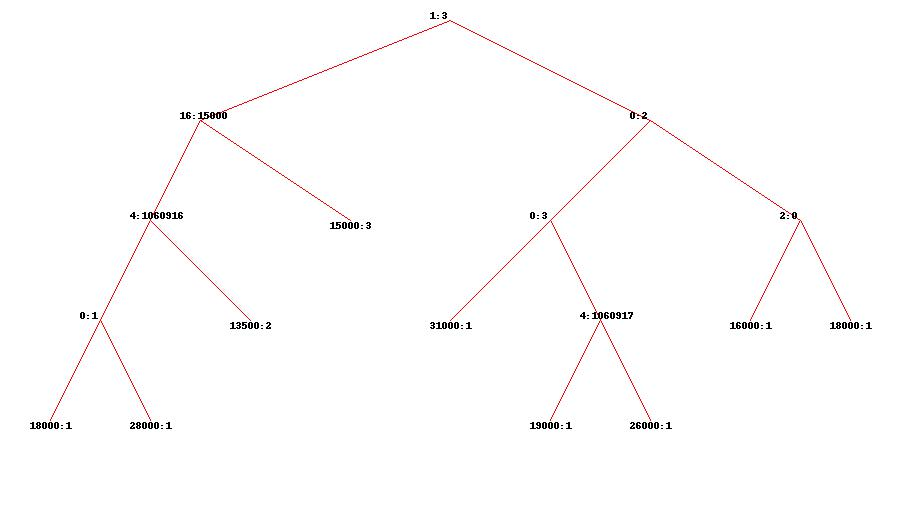

In [416]:
from IPython.display import Image
Image(filename='treeview.jpg')